# see what angles get reconstructed well

In [2]:
import jkutils
import os, sys
import numpy as np
import scipy.stats as stats
from keras.models import load_model
import math
import shelve
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

energy, azmiuth, zenith, muex = 0, 1, 2, 3

Using Theano backend.
/home/jkager/.local/lib/python2.7/site-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [3]:
os.listdir('/data/user/jkager/NN_Reco/training_data_20x10x60/training_data')

['11029_05000-05999.h5',
 '11029_01000-01999.h5',
 '11029_04000-04999.h5',
 '11069_06000-06999.h5',
 '11069_04000-04999.h5',
 '11069_05000-05999.h5',
 '11069_03000-03999.h5',
 '11069_00000-00999.h5',
 '11029_00000-00999.h5',
 '11029_02000-02999.h5',
 '11029_03000-03999.h5',
 '11069_02000-02999.h5',
 '11069_01000-01999.h5']

following code loads the saved model from final_network.h5 and tests the testdatasets on it (saves to res and train_out)

In [4]:
file_location = '/data/user/jkager/NN_Reco/johannes/updownclassification_2/'
data_location = '/data/user/jkager/NN_Reco/training_data_20x10x60/'

today = '2017-08-03'
project_name = 'charge_all_v2'

project_folder = 'train_hist/{}/{}'.format(today, project_name)
print "looking for", project_folder
if not os.path.exists('{}'.format(os.path.join(file_location,project_folder))):
    print "project not found. exiting..."
    sys.exit(-1)
shelf = shelve.open(os.path.join(file_location, project_folder, 'run_info.shlf'))
input_files = shelf['Files'].split(':')
if input_files[0] == 'all':
    input_files = [f for f in os.listdir(os.path.join(data_location, 'training_data/')) 
                   if True or os.path.isfile(os.path.join(data_location,f))]
print input_files[0], os.path.isfile(os.path.join(data_location,input_files[0]))
print os.path.join(data_location,input_files[0])
sys.exit()
train_inds = shelf['Train_Inds'] 
valid_inds = shelf['Valid_Inds']
test_inds = shelf['Test_Inds']
inf_times_as = shelf['inf_times_as']
try:
    using = shelf['using']
except KeyError:
    using = 'time'
shelf.close()

input_data, out_data, file_len = jkutils.read_files(input_files, data_location, using=using)
print('\n Load the Model (final_network.h5) \n')
model = load_model(os.path.join(\
file_location,'train_hist/{}/{}/final_network.h5'.format(today, project_name)))

print('\n Calculate Results... \n')
res = []
test_out = []

if using == 'charge':
    preprocess = jkutils.fake_preprocess
else:
    preprocess = jkutils.preprocess
for i in range(len(input_data)):
    print('Predict Values for {}'.format(input_files.split(':')[i]))
    test_in_chunk  = np.array(map(np.ndarray.flatten, jkutils.preprocess(input_data[i][test_inds[i][0]:test_inds[i][1]],
                                                                        inf_times_as)))
    test_out_chunk = out_data[i][test_inds[i][0]:test_inds[i][1],zenith:zenith+1]
    res_chunk = model.predict(test_in_chunk, verbose=3)
    res.extend(list(res_chunk))
    test_out.extend(list(test_out_chunk))
    break

res = np.squeeze(res)
test_out = np.squeeze(test_out)
p = test_out.argsort() # sort zeniths
res = res[p]
test_out = test_out[p]
correct = np.sum(res == jkutils.zenith_to_binary(test_out))
total = len(res)
print "{} / {} = {:6.2f}%".format(correct, total, float(correct)/total*100)

looking for train_hist/2017-08-03/charge_all_v2


KeyError: 'Files'

In [14]:
# sns.distplot(res) -> does not work because input is just ones (res = [1,1,1,1,...])

In [12]:
splits = 19
x_hist = np.linspace(0,math.pi,splits)
y_hist = np.zeros((splits-1))
cor, summe = 0, 0
for i in range(len(x_hist)-1):
    indizes = np.bitwise_and(test_out >= x_hist[i], test_out < x_hist[i+1])
    correct = np.sum(res[indizes] == jkutils.zenith_to_binary(test_out[indizes]))
    print correct, np.sum(indizes), x_hist[i] * 180/math.pi
    cor += correct
    summe += np.sum(indizes)
    y_hist[i] = float(correct)/np.sum(indizes)
print cor / float(summe)

0 197 0.0
0 467 10.0
0 661 20.0
0 752 30.0
0 838 40.0
0 1028 50.0
0 1278 60.0
0 1499 70.0
0 1782 80.0
1868 1868 90.0
1680 1680 100.0
1633 1633 110.0
1487 1487 120.0
1233 1233 130.0
1008 1008 140.0
763 763 150.0
496 496 160.0
171 171 170.0
0.548750066345


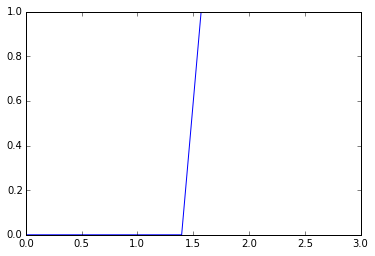

In [6]:
plt.plot(x_hist[:-1],y_hist)

In [ ]:
y_hist_items=[]
for x, y in zip(x_hist[:-1],y_hist):
    x = x * 180 / math.pi
    y_hist_items.extend([x+5] * int(y * 100))

# analyze test_results

In [5]:
file_location = '/data/user/jkager/NN_Reco/johannes/updownclassification_3/'
data_location = '/data/user/jkager/NN_Reco/training_data_20x10x60/training_data'

today = '2017-08-24'
project_name = 'time_h012_v1'
file_name = 'test_results.npy'

project_folder = 'train_hist/{}/{}'.format(today, project_name)
print "looking for", project_folder
if not os.path.exists(os.path.join(file_location,project_folder)):
    print "project not found. exiting..."
    sys.exit(-1)
elif not os.path.exists(os.path.join(file_location, project_folder, file_name)):
    print "file not found. exiting..."
    sys.exit(-1)
print "found"
test_results = np.load(os.path.join(file_location, project_folder, file_name))

looking for train_hist/2017-08-24/time_h012_v1
found


In [10]:
true_pos, true_neg = 0, 0
false_pos, false_neg = 0, 0
reals, preds = [], []
for pred, real in zip(test_results[0], test_results[1]):
    if real == 1:
        if pred < 0.5:
            false_neg += 1
        else:
            true_pos += 1
    if real == 0:
        if pred > 0.5:
            false_pos += 1
        else:
            true_neg += 1
    reals.append(real)
    preds.append(pred)

In [7]:
print "         |    pos    |    neg    "
print "---------+-----------+-----------"
sum_all = true_pos + false_pos + true_neg + false_neg
if sum_all == 0:
    print "no data"
print "test pos |{:10.2f}%|{:10.2f}%".format(100 * true_pos / float(sum_all), 100 * false_pos / float(sum_all))
print "test neg |{:10.2f}%|{:10.2f}%".format(100 * false_neg / float(sum_all), 100 * true_neg / float(sum_all))


print "---------+-----------+-----------\n"*2,    
print "         |    pos    |    neg    "
print "---------+-----------+-----------" 
print "test pos |{:11.0f}|{:11.0f}".format(100 * true_pos, 100 * false_pos)
print "test neg |{:11.0f}|{:11.0f}".format(100 * false_neg, 100 * true_neg)

         |    pos    |    neg    
---------+-----------+-----------
test pos |     51.25%|      4.44%
test neg |      2.82%|     41.49%
---------+-----------+-----------
---------+-----------+-----------
         |    pos    |    neg    
---------+-----------+-----------
test pos |    6423500|     556100
test neg |     353700|    5200300


In [9]:
print "\n".join(map(str, zip(reals, preds)))

(1.0, 0.9986264705657959)
(1.0, 0.16152086853981018)
(0.0, 0.00034043632331304252)
(1.0, 0.99805128574371338)
(1.0, 0.99730503559112549)
(1.0, 0.99995172023773193)
(1.0, 0.99906235933303833)
(1.0, 0.99985742568969727)
(0.0, 1.0549966646067332e-05)
(1.0, 0.97882163524627686)
(1.0, 0.18986433744430542)
(1.0, 0.95469653606414795)
(0.0, 0.0014480318641290069)
(1.0, 0.31810095906257629)
(1.0, 0.99770206212997437)
(0.0, 0.19017940759658813)
(1.0, 0.99577635526657104)
(0.0, 0.003799935569986701)
(1.0, 0.99764388799667358)
(1.0, 0.98945504426956177)
(1.0, 0.99902582168579102)
(1.0, 0.9982638955116272)
(1.0, 0.99820089340209961)
(0.0, 0.0076321708038449287)
(1.0, 0.9993627667427063)
(1.0, 0.97248071432113647)
(1.0, 0.99826329946517944)
(0.0, 0.0073660095222294331)
(1.0, 0.89859479665756226)
(0.0, 0.01819021999835968)
(1.0, 0.99906164407730103)
(1.0, 0.98411464691162109)
(0.0, 0.31598615646362305)
(1.0, 0.75635993480682373)
(0.0, 0.005715253297239542)
(0.0, 0.15248973667621613)
(1.0, 0.999982476

## last activation function as linout to see what the outputs are

In [15]:
file_location = '/data/user/jkager/NN_Reco/johannes/updownclassification_2/'
data_location = '/data/user/jkager/NN_Reco/'

today = '2017-07-30'
project_name = 'time10_h0_v1_linout'

project_folder = 'train_hist/{}/{}'.format(today, project_name)
print "looking for", project_folder
if not os.path.exists('{}'.format(os.path.join(file_location,project_folder))):
    print "project not found. exiting..."
    sys.exit(-1)

looking for train_hist/2017-07-30/time10_h0_v1_linout


In [16]:
test_results = np.load(os.path.join(project_folder, 'test_results.npy'))

In [17]:
for pred, real in zip(test_results[0], test_results[1]):
    print real, pred

1.0 65543.0546875
1.0 64762.3398438
1.0 65106.0507812
1.0 65384.328125
0.0 64725.1835938
1.0 65454.0351562
0.0 65085.5273438
1.0 65336.6484375
0.0 65218.7851562
0.0 64109.1054688
0.0 64980.9101562
1.0 64911.8242188
1.0 65517.2382812
1.0 65255.9023438
1.0 65441.6445312
1.0 64516.2109375
0.0 63926.1640625
1.0 64926.2929688
1.0 65500.390625
0.0 64425.2460938
0.0 65362.3242188
1.0 65313.4101562
1.0 65203.2539062
1.0 65492.7851562
1.0 65361.5351562
1.0 65497.6367188
1.0 65392.8476562
1.0 65255.6445312
0.0 64625.703125
1.0 65258.4882812
1.0 65023.2421875
1.0 65478.3007812
0.0 64074.6640625
0.0 64670.8671875
1.0 64478.7773438
0.0 65449.6132812
1.0 65536.859375
0.0 64226.0117188
1.0 64739.5429688
0.0 65335.7109375
1.0 65542.1328125
1.0 64529.84375
0.0 64474.7734375
1.0 65555.4375
0.0 65109.4257812
1.0 65504.7070312
1.0 65115.2460938
1.0 65435.4765625
1.0 65072.0625
1.0 65504.2578125
1.0 65260.0976562
1.0 65447.2226562
1.0 65398.671875
1.0 65454.7851562
0.0 65019.9453125
1.0 65527.390625
0.0 64